In [26]:
import sys
from pathlib import Path

project_root = Path().cwd().parent.resolve().parent.parent / 'src' / 'nanoCocoa_aiserver'
sys.path.insert(0, str(project_root))

print(str(project_root))

/home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver


In [27]:
import helper_plot_hangul
import importlib
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle
from typing import List, Optional
from helper_plot_hangul import matplotlib_font_reset, matplotlib_font_get
from diffusers.utils import load_image
print(matplotlib_font_get())


{'font_family': 'NanumGothic', 'font_path': '/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/helper_plot_hangul/fonts/NanumGothic.ttf'}


In [28]:
import os
import logging
import torch
import logging
from helper_dev_utils import get_auto_logger
# ==========================================
# 설정 & 상수 (Configuration)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16

# 모델 ID 정의
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

# 예상 소요 시간 (초 단위, 초기값)
ESTIMATED_TIMES = {
    "init": 30,
    "stage_a": 300,  # 배경 생성 및 합성
    "stage_b": 200,  # 텍스트 자산 생성
    "stage_c": 90,   # 최종 합성 (Flux Inpainting 추가: 28 steps ≈ 30초)
}
TOTAL_ESTIMATED_TIME = sum(ESTIMATED_TIMES.values())

# 로깅 설정
logger = get_auto_logger()



In [29]:
import torch
import warnings
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from config import DEVICE
from utils import flush_gpu

# timm 라이브러리 deprecation 경고 억제
warnings.filterwarnings("ignore", category=FutureWarning, module="timm")

class SegmentationModel:
    """
    BiRefNet을 사용하여 이미지 세그멘테이션(배경 제거)을 수행하는 클래스입니다.
    """
    def __init__(self):
        self.device = DEVICE

    def run(self, image: Image.Image) -> tuple[Image.Image, Image.Image]:
        """
        이미지의 배경을 제거합니다.
        
        Args:
            image (Image.Image): 입력 이미지
            
        Returns:
            tuple[Image.Image, Image.Image]: (배경 제거된 이미지, 마스크)
        """
        logger.debug("[Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)")
        flush_gpu()
        
        model = AutoModelForImageSegmentation.from_pretrained(
            MODEL_IDS["SEG"], trust_remote_code=True
        ).to(self.device).eval()

        W, H = image.size
        # 고해상도 처리를 위해 리사이즈 (필요 시 조정 가능)
        img_resized = image.resize((1024, 1024), Image.LANCZOS)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            preds = model(input_tensor)[-1].sigmoid().cpu()
        
        pred = preds[0].squeeze()
        mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
        
        # 마스크 이진화 (Thresholding)
        mask = mask.point(lambda x: 255 if x > 128 else 0)
        
        result = image.copy()
        result.putalpha(mask)
        
        # 리소스 정리
        del model, input_tensor
        flush_gpu()
        
        return result, mask

segmenter = SegmentationModel()
logger.debug("로딩 성공")

2026-01-06 14:26:06 D [ipykernel_launcher:66] - 로딩 성공


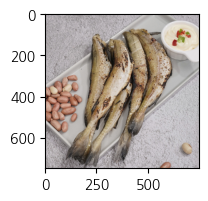

In [30]:
image_png = load_image("image.png").convert("RGB")
plt.figure(figsize=(2, 2))
plt.imshow(image_png)

In [31]:
if "segmenter" in globals():
    del segmenter
    segmenter = None
    segmenter = SegmentationModel()
flush_gpu()

sm_result, sm_mask = segmenter.run(image_png)
# 저장
sm_result.save("image_result.png")
sm_mask.save("image_mask.png")

2026-01-06 14:26:07 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)


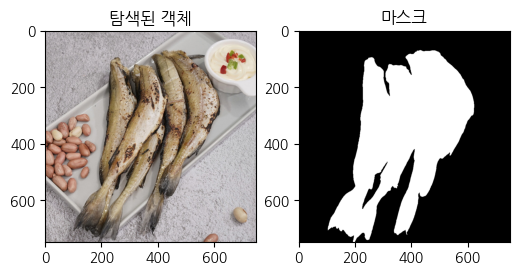

In [32]:
image_result_png = load_image("image_result.png")
image_mask_png = load_image("image_mask.png")

plt.figure(figsize=(6, 3))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(image_result_png)
ax1.set_title("탐색된 객체")

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(image_mask_png)
ax2.set_title("마스크")
plt.show()

In [33]:

import torch
import gc
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from diffusers import (
    FluxPipeline,
    FluxImg2ImgPipeline,
    FluxInpaintPipeline,
    FluxTransformer2DModel
)
from transformers import BitsAndBytesConfig
from config import TORCH_DTYPE, logger
from utils import flush_gpu

class FluxGenerator:
    """
    FLUX 모델을 사용하여 배경 생성, 이미지 리파인, 지능형 합성을 수행하는 클래스입니다.
    """
    
    def __init__(self):
        self._prompt = []
        self._negative = []

    def base_prompt(
        self,
        prompt: list[str],
        negative: list[str],
    ) -> None:
        self._prompt = prompt
        self._negative = negative

    
    def position_analysis(
        self,
        background: Image.Image,
        threshold_percentile: int = 40,
        min_area: float = 0.15
    ) -> tuple:
        """
        MaskGenerator.recommend_position()의 분석 과정을 시각화하여 이미지로 반환합니다.

        Args:
            background: 분석할 배경 이미지
            threshold_percentile: 밝기 임계값 (기본 40)
            min_area: 최소 면적 비율

        Returns:
            tuple: (추천 위치, scores 딕셔너리, 분석 이미지 dict)
                  images = {
                      'original': 원본 이미지,
                      'regions': 3개 영역 구분 오버레이,
                      'binary_mask': 이진 마스크,
                      'edges': 엣지 검출,
                      'histogram': 밝기 히스토그램,
                      'bar_chart': 점수 비교 바 차트
                  }
        """
        # 1. 동일한 알고리즘으로 위치 계산
        w, h = background.size
        bg_gray = background.convert("L")
        bg_arr = np.array(bg_gray)
        threshold = np.percentile(bg_arr, threshold_percentile)
        mask_arr = (bg_arr < threshold)  # True for dark areas (empty space)
        
        # 영역별 여백 점수 계산
        top_area = mask_arr[0:int(h*0.33), :].sum()
        center_area = mask_arr[int(h*0.33):int(h*0.66), :].sum()
        bottom_area = mask_arr[int(h*0.66):h, :].sum()
        
        scores = {
            "top": int(top_area),
            "center": int(center_area),
            "bottom": int(bottom_area)
        }
        
        # 최적 위치 결정
        best_position = max(scores, key=scores.get)
        total_pixels = w * h
        if scores[best_position] / (total_pixels / 3) < min_area:
            best_position = "top"
        
        # 2. 시각화 이미지 생성
        images = {}
        
        # 이미지 1: 원본 이미지 (제목 추가)
        img_original = background.copy()
        draw = ImageDraw.Draw(img_original)
        try:
            font_large = ImageFont.truetype(matplotlib_font_get()['font_path'], 40)
        except:
            font_large = ImageFont.load_default()
            
        draw.text((w//2, 30), f'추천 위치: {best_position}', fill='yellow', 
                 anchor='mm', font=font_large, stroke_width=2, stroke_fill='black')
        images['original'] = img_original
        
        # 이미지 2: 3개 영역 구분 오버레이
        overlay = np.array(background.convert("RGB")).copy()
        region_height = int(h * 0.33)
        
        # 상단 (빨강), 중앙 (초록), 하단 (파랑)
        overlay[0:region_height, :, 0] = np.clip(overlay[0:region_height, :, 0] + 80, 0, 255)
        overlay[region_height:region_height*2, :, 1] = np.clip(overlay[region_height:region_height*2, :, 1] + 80, 0, 255)
        overlay[region_height*2:h, :, 2] = np.clip(overlay[region_height*2:h, :, 2] + 80, 0, 255)
        
        img_regions = Image.fromarray(overlay)
        draw = ImageDraw.Draw(img_regions)
        try:
            font_med = ImageFont.truetype(matplotlib_font_get()['font_path'], 30)
        except:
            font_med = ImageFont.load_default()
        
        draw.text((w//2, region_height//2), f'상단\n점수: {scores["top"]:,}', 
                 fill='white', anchor='mm', font=font_med, stroke_width=2, stroke_fill='red')
        draw.text((w//2, region_height + region_height//2), f'중앙\n점수: {scores["center"]:,}', 
                 fill='white', anchor='mm', font=font_med, stroke_width=2, stroke_fill='green')
        draw.text((w//2, region_height*2 + (h - region_height*2)//2), f'하단\n점수: {scores["bottom"]:,}', 
                 fill='white', anchor='mm', font=font_med, stroke_width=2, stroke_fill='blue')
        images['regions'] = img_regions
        
        # 이미지 3: 이진 마스크
        img_mask = Image.fromarray((mask_arr * 255).astype(np.uint8), mode='L')
        images['binary_mask'] = img_mask
        
        # 이미지 4: 엣지 검출
        bg_gray_np = np.array(bg_gray)
        edges = cv2.Canny(bg_gray_np, 100, 200)
        img_edges = Image.fromarray(edges, mode='L')
        images['edges'] = img_edges
        
        # image_canny = np.array(background)
        # image_canny = cv2.Canny(image_canny, 50, 150) 
        # image_canny = image_canny[:, :, None]
        # image_canny = np.concatenate([image_canny, image_canny, image_canny], axis=2)
        # images['canny_edges'] = Image.fromarray(image_canny)
        
        # 이미지 5: 밝기 히스토그램 (matplotlib -> PIL)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.hist(bg_arr.flatten(), bins=256, range=(0, 256), color='gray', alpha=0.7)
        ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'임계값: {threshold:.1f}')
        ax.set_title('밝기 분포 히스토그램', fontsize=14)
        ax.set_xlabel('밝기 값 (0-255)', fontsize=11)
        ax.set_ylabel('픽셀 수', fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        img_histogram = Image.open(buf).copy()
        plt.close(fig)
        images['histogram'] = img_histogram
        
        # 이미지 6: 점수 비교 바 차트 (matplotlib -> PIL)
        fig, ax = plt.subplots(figsize=(8, 6))
        positions = list(scores.keys())
        values = list(scores.values())
        colors = ['red' if p == best_position else 'lightgray' for p in positions]
        bars = ax.bar(positions, values, color=colors, alpha=0.8)
        
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:,}',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax.set_title('영역별 점수 비교', fontsize=14)
        ax.set_xlabel('위치', fontsize=11)
        ax.set_ylabel('어두운 픽셀 수', fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        img_barchart = Image.open(buf).copy()
        plt.close(fig)
        images['bar_chart'] = img_barchart
        
        return best_position, scores, images
    
    def generate_background(self, prompt: str, negative_prompt: str = None, guidance_scale: float = 3.5, seed: int = None, num_steps=25, progress_callback=None) -> Image.Image:
        """
        텍스트 프롬프트를 기반으로 배경 이미지를 생성합니다.
        
        Args:
            prompt (str): 배경 생성 프롬프트
            negative_prompt (str, optional): 배제할 요소들에 대한 부정 프롬프트
            guidance_scale (float): 프롬프트 준수 강도
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백 함수
            
        Returns:
            Image.Image: 생성된 이미지
        """
        logger.debug("[Engine] Loading FLUX (Text-to-Image)... (FLUX 텍스트-이미지 모델 로딩 중)")
        flush_gpu()
        
        _prompt = " ".join([prompt] + self._prompt) if prompt else " ".join(self._prompt)
        _negative = " ".join([negative_prompt] + self._negative) if negative_prompt else " ".join(self._negative)
        
        quant_config = BitsAndBytesConfig(load_in_4bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
        )
        pipe = FluxPipeline.from_pretrained(
            MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()

        generator = None
        if seed is not None:
             generator = torch.Generator("cpu").manual_seed(seed)
        else:
             generator = torch.Generator("cpu").manual_seed(42)

        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            logger.debug(f"[FluxGenerator] {step_index}/{num_steps} {timestep}")
            if progress_callback:
                progress_callback(step_index + 1, num_steps, "flux_bg_generation")
            return callback_kwargs
        
        logger.debug(f"[FluxGenerator] {_prompt}")
        logger.debug(f"[FluxGenerator] {_negative}")
        image = pipe(
            _prompt, negative_prompt=_negative, height=1024, width=1024, 
            num_inference_steps=num_steps, guidance_scale=guidance_scale,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]
        
        del pipe, transformer
        flush_gpu()
        return image

    def refine_image(self, draft_image: Image.Image, prompt: str = None, negative_prompt: str = None, strength: float = 0.6, guidance_scale: float = 3.5, seed: int = None, progress_callback=None) -> Image.Image:
        """
        이미지를 리터칭(Img2Img, 배경 합성)하여 품질을 높입니다.
        
        Args:
            draft_image (Image.Image): 초안 이미지
            prompt (str): 배경 합성 프롬프트 (없을 경우 기본값 사용)
            negative_prompt (str): 배경 합성 부정 프롬프트 (없을 경우 기본값 사용)
            strength (float): 변환 강도
            guidance_scale (float): 프롬프트 준수 강도
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백 함수
            
        Returns:
            Image.Image: 리터칭된 배경 합성 이미지
        """
        logger.debug("[Engine] Loading FLUX (Img-to-Img for Background Composition)... (FLUX 배경 합성 모델 로딩 중)")
        flush_gpu()
        
        quant_config = BitsAndBytesConfig(load_in_8bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
        )
        pipe = FluxImg2ImgPipeline.from_pretrained(
            MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()

        _prompt = " ".join([prompt] + self._prompt) if prompt else " ".join(self._prompt)
        _negative = " ".join([negative_prompt] + self._negative) if negative_prompt else " ".join(self._negative)

        generator = None
        if seed is not None:
             generator = torch.Generator("cpu").manual_seed(seed)
        else:
             generator = torch.Generator("cpu").manual_seed(42)

        num_steps = 30
        
        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            if progress_callback:
                progress_callback(step_index + 1, num_steps, "flux_bg_composition_refinement")
            return callback_kwargs

        refined_image = pipe(
            prompt=_prompt,
            negative_prompt=_negative,
            image=draft_image, 
            strength=strength, 
            num_inference_steps=num_steps, 
            guidance_scale=guidance_scale,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]

        del pipe, transformer
        flush_gpu()
        return refined_image

    def dilate_mask(self, mask: Image.Image, kernel_size: int) -> Image.Image:
        """
        마스크를 확장(Dilation)하여 페더링 효과와 그림자 생성 영역을 확보합니다.
        
        Args:
            mask (Image.Image): 원본 마스크
            kernel_size (int): 커널 크기 (확장 범위)
            
        Returns:
            Image.Image: 확장된 마스크
        """
        if kernel_size <= 0:
            return mask
            
        mask_np = np.array(mask)
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        dilated = cv2.dilate(mask_np, kernel, iterations=1)
        return Image.fromarray(dilated)

    def build_injection_prompt(self, background_prompt: str, product_description: str) -> str:
        """
        배경 프롬프트와 상품 설명을 조합하여 주입용 프롬프트를 생성합니다.
        """
        # 간단한 결합. 필요시 복잡한 로직 추가 가능
        return f"{background_prompt}, {product_description}"

    def extend_negative_prompt(self, negative_prompt: str) -> str:
        """
        기존 부정 프롬프트를 확장합니다.
        """
        return negative_prompt if negative_prompt else ""

    def inject_features_via_inpaint(
        self,
        background: Image.Image,
        product_foreground: Image.Image,
        product_mask: Image.Image,
        position: tuple,
        prompt: str,
        negative_prompt: str = None,
        strength: float = 0.5,
        guidance_scale: float = 3.5,
        num_inference_steps: int = 28,
        mask_dilation: int = 0,
        seed: int = None,
        progress_callback=None
    ) -> Image.Image:
        """
        Flux Inpainting을 사용하여 상품의 특성을 배경에 주입합니다.
        
        프로세스:
        1. 배경 이미지에 상품 위치 마스킹
        2. 상품 영역에 Inpainting으로 특성 주입
        3. 결과: 상품이 배경과 자연스럽게 통합된 이미지
        
        Args:
            background (Image.Image): 배경 이미지
            product_foreground (Image.Image): 상품 이미지 (투명 배경, RGBA)
            product_mask (Image.Image): 상품 마스크 (L 모드, 255=상품 영역)
            position (tuple): 상품 배치 위치 (x, y)
            prompt (str): 특성 주입 프롬프트
            negative_prompt (str, optional): 부정 프롬프트
            strength (float): Inpainting 강도 (0.0~1.0)
            guidance_scale (float): 프롬프트 준수 강도
            num_inference_steps (int): 추론 스텝 수
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백
            
        Returns:
            Image.Image: 특성이 주입된 최종 이미지
        """
        logger.info("[FluxGenerator] Loading FLUX Inpainting for feature injection...")
        flush_gpu()
        
        # Flux Inpainting 파이프라인 로드
        quant_config = BitsAndBytesConfig(load_in_8bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], 
            subfolder="transformer", 
            quantization_config=quant_config, 
            torch_dtype=TORCH_DTYPE
        )
        pipe = FluxInpaintPipeline.from_pretrained(
            MODEL_IDS["FLUX"], 
            transformer=transformer, 
            torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()
        
        # 초안 이미지 생성 (상품을 배경에 임시 배치)
        draft = background.copy().convert("RGBA")
        draft.paste(product_foreground, position, product_foreground)
        draft_rgb = draft.convert("RGB")
        
        # 마스크 확장 (그림자 영역 확보)
        if mask_dilation > 0:
            logger.info(f"[FluxGenerator] Dilating mask by {mask_dilation} pixels for natural shadows...")
            final_mask = self.dilate_mask(product_mask, mask_dilation)
        else:
            final_mask = product_mask
        
        # Generator 설정
        generator = None
        if seed is not None:
            generator = torch.Generator("cpu").manual_seed(seed)
        else:
            generator = torch.Generator("cpu").manual_seed(42)
        
        # Progress callback
        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            if progress_callback:
                progress_callback(step_index + 1, num_inference_steps, "flux_feature_injection")
            return callback_kwargs
        
        _prompt = " ".join([prompt] + self._prompt) if prompt else " ".join(self._prompt)
        _negative = " ".join([negative_prompt] + self._negative) if negative_prompt else " ".join(self._negative)
        
        logger.info(f"[FluxGenerator] prompt='{_prompt}'")
        logger.info(f"[FluxGenerator] negative_prompt='{_negative}'")
        logger.info(f"[FluxGenerator] strength='{strength}', guidance_scale={guidance_scale}, steps={num_inference_steps}")
        
        # Inpainting 실행 (상품 영역만 재생성하여 특성 주입)
        result = pipe(
            prompt=_prompt,
            negative_prompt=_negative,
            image=draft_rgb,
            mask_image=final_mask,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]
        
        logger.info("[FluxGenerator] Feature injection completed")
        
        del pipe, transformer
        flush_gpu()
        
        return result

    def inpaint_composite(
        self,
        background: Image.Image,
        text_asset: Image.Image,
        mask: Image.Image,
        prompt: str,
        negative_prompt: str = None,
        strength: float = 0.4,
        guidance_scale: float = 3.5,
        num_inference_steps: int = 28,
        mask_dilation: int = 0,
        seed: int = None,
        progress_callback=None
    ) -> Image.Image:
        """
        Flux Inpainting을 사용하여 텍스트를 배경과 맥락적으로 합성합니다.
        
        Args:
            background (Image.Image): 배경 이미지
            text_asset (Image.Image): 텍스트 에셋 (RGBA)
            mask (Image.Image): 합성 영역 마스크 (255=인페인팅, 0=보존)
            prompt (str): 합성 프롬프트
            strength (float): 변환 강도 (0.0~1.0)
            guidance_scale (float): 프롬프트 준수 강도
            num_inference_steps (int): 추론 스텝 수 (품질 우선: 28~50)
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백
            
        Returns:
            Image.Image: 합성된 최종 이미지
        """
        logger.info("[FluxGenerator] Loading FLUX Inpainting for composition...")
        flush_gpu()
        
        # Flux Inpainting 파이프라인 로드
        quant_config = BitsAndBytesConfig(load_in_8bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], 
            subfolder="transformer", 
            quantization_config=quant_config, 
            torch_dtype=TORCH_DTYPE
        )
        pipe = FluxInpaintPipeline.from_pretrained(
            MODEL_IDS["FLUX"], 
            transformer=transformer, 
            torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()
        
        # 초안 합성 (텍스트를 배경에 배치)
        draft = background.copy().convert("RGBA")
        text_resized = text_asset.resize(draft.size, Image.LANCZOS)
        draft.paste(text_resized, (0, 0), text_resized)
        draft_rgb = draft.convert("RGB")
        
        # 마스크 확장 (그림자 영역 확보)
        if mask_dilation > 0:
            logger.info(f"[FluxGenerator] Dilating mask by {mask_dilation} pixels for natural shadows...")
            final_mask = self.dilate_mask(product_mask, mask_dilation)
        else:
            final_mask = product_mask
        
        # Generator 설정
        generator = None
        if seed is not None:
            generator = torch.Generator("cpu").manual_seed(seed)
        else:
            generator = torch.Generator("cpu").manual_seed(42)
        
        # Progress callback
        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            if progress_callback:
                progress_callback(step_index + 1, num_inference_steps, "flux_inpaint_composite")
            return callback_kwargs
        
        
        _prompt = " ".join([prompt] + self._prompt) if prompt else " ".join(self._prompt)
        _negative = " ".join([negative_prompt] + self._negative) if negative_prompt else " ".join(self._negative)
        
        
        logger.info(f"[FluxGenerator] Running inpainting: prompt='{prompt[:50]}...', steps={num_inference_steps}")
        
        # Inpainting 실행
        result = pipe(
            prompt=_prompt,
            negative_prompt=_negative,
            image=draft_rgb,
            mask_image=mask,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]
        
        logger.info("[FluxGenerator] Inpainting composition completed")
        
        del pipe, transformer
        flush_gpu()
        
        return result

flux_gen = FluxGenerator()
logger.debug("로딩 성공")

2026-01-06 14:26:21 D [config:541] - 로딩 성공


In [34]:
num_steps = 1

def progress_callback(step, total, sub_step_name):
    logger.debug(f"[Test Progress] {sub_step_name}: {step}/{total}")


In [35]:

# 공통 배경 요소 정의
# 공통 배경 요소
background_scene = "A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark."
# → 영화적인 분위기의 사진, 햇살이 들어오는 방 안에 놓인 오래된 나무 농가 테이블
# → 따뜻한 햇살이 거친 테이블 표면을 가로질러 비추며 먼지 입자와 깊은 질감을 드러냄
# → 오래되어 바래고 어두운 색을 띠는 나무

background_style = "Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k."
# → 얕은 심도(배경 흐림, 테이블에 초점), 매우 디테일한 표현
# → 소박하고 시골스러운 분위기, 사진처럼 사실적인 표현
# → 초고해상도 8K 품질

# 공통 부정 요소
common_negative = "blurry, low quality, artificial, plastic, oversaturated, bad lighting"
# → 흐릿한, 저화질, 인위적인, 플라스틱 같은 질감
# → 과도하게 채도가 높은, 조명이 나쁜 표현은 배제

flux_gen.base_prompt(
    prompt=[
        background_scene,
        background_style
    ],
    negative=[
        common_negative
    ]
)


2026-01-06 14:26:22 D [config:198] - [Engine] Loading FLUX (Text-to-Image)... (FLUX 텍스트-이미지 모델 로딩 중)


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-06 14:29:52 D [config:225] - [FluxGenerator] A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark. Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k.
2026-01-06 14:29:52 D [config:226] - [FluxGenerator] banana, fruit, food, smooth surface, new wood blurry, low quality, artificial, plastic, oversaturated, bad lighting


  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-06 14:32:57 D [config:220] - [FluxGenerator] 0/14 1000.0
2026-01-06 14:32:57 D [config:4] - [Test Progress] flux_bg_generation: 1/14
2026-01-06 14:33:05 D [config:220] - [FluxGenerator] 1/14 976.2224731445312
2026-01-06 14:33:05 D [config:4] - [Test Progress] flux_bg_generation: 2/14
2026-01-06 14:33:12 D [config:220] - [FluxGenerator] 2/14 949.87255859375
2026-01-06 14:33:12 D [config:4] - [Test Progress] flux_bg_generation: 3/14
2026-01-06 14:33:19 D [config:220] - [FluxGenerator] 3/14 920.5089721679688
2026-01-06 14:33:19 D [config:4] - [Test Progress] flux_bg_generation: 4/14
2026-01-06 14:33:27 D [config:220] - [FluxGenerator] 4/14 887.5834350585938
2026-01-06 14:33:27 D [config:4] - [Test Progress] flux_bg_generation: 5/14
2026-01-06 14:33:34 D [config:220] - [FluxGenerator] 5/14 850.4057006835938
2026-01-06 14:33:34 D [config:4] - [Test Progress] flux_bg_generation: 6/14
2026-01-06 14:33:41 D [config:220] - [FluxGenerator] 6/14 808.0955200195312
2026-01-06 14:33:41 D [co

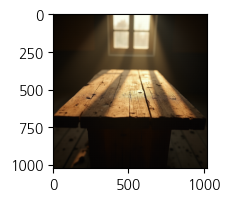

In [36]:
flush_gpu()
# Step 1: 배경 생성 (상품 없음)
background = flux_gen.generate_background(
    prompt=None,
    negative_prompt="banana, fruit, food, smooth surface, new wood",
    guidance_scale=3.5,
    seed=42,
    num_steps=14, # 기본 25 테스트를 위하여 3회만
    progress_callback=progress_callback
)

if "flux_gen" in globals():
    del flux_gen
    flux_gen = None
    logger.debug("기존 flux_gen 인스턴스 삭제")

flush_gpu()
logger.debug("Background generated")
background.save("background.png")
    
plt.figure(figsize=(2, 2))
plt.imshow(background)

In [37]:
# QwenVLAnalyzer: 이미지 분석, 객체 탐지, 텍스트 배치 추천 클래스
import os
import json
import torch
from PIL import Image
from qwen_vl_utils import process_vision_info
from transformers import AutoProcessor
from vllm import LLM, SamplingParams

# vLLM 멀티프로세스 설정 (클래스 정의 전에 설정 필수)
os.environ['VLLM_WORKER_MULTIPROC_METHOD'] = 'spawn'

class QwenVLAnalyzer:
    """
    Qwen/Qwen3-VL-8B-Instruct-FP8 모델을 사용하여 이미지 분석, 객체 탐지, 텍스트 배치 추천을 수행하는 클래스
    """
    
    def __init__(self, model_id: str = "Qwen/Qwen3-VL-8B-Instruct-FP8", device: str = "cuda", gpu_memory_utilization: float = 0.70):
        """
        QwenVLAnalyzer 초기화
        
        Args:
            model_id (str): 사용할 Qwen VL 모델 ID
            device (str): 실행 디바이스 (cuda/cpu)
            gpu_memory_utilization (float): GPU 메모리 사용률 (0.0~1.0)
        """
        self.model_id = model_id
        self.device = device
        self.gpu_memory_utilization = gpu_memory_utilization
        
        logger.info(f"[QwenVLAnalyzer] Loading model: {model_id}")
        
        # Processor 로드
        self.processor = AutoProcessor.from_pretrained(model_id)
        
        # LLM 로드 (vLLM 사용) - 단일 GPU 설정
        self.llm = LLM(
            model=model_id,
            trust_remote_code=True,
            gpu_memory_utilization=gpu_memory_utilization,
            max_model_len=8192,
            enforce_eager=True,  # 멀티프로세스 회피
            tensor_parallel_size=1,  # 단일 GPU 사용
            seed=0,
            disable_log_stats=True
        )
        
        logger.info(f"[QwenVLAnalyzer] Model loaded successfully")
    
    def _prepare_inputs(self, messages):
        """
        vLLM용 입력 준비
        
        Args:
            messages (list): 채팅 메시지 리스트
            
        Returns:
            dict: vLLM 입력 데이터
        """
        text = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        logger.debug(f"[QwenVLAnalyzer] messages: {messages}")
        logger.debug(f"[QwenVLAnalyzer] text: {text}")
        
        # process_vision_info로 이미지/비디오 처리
        image_inputs, video_inputs, video_kwargs = process_vision_info(
            messages,
            image_patch_size=self.processor.image_processor.patch_size,
            return_video_kwargs=True,
            return_video_metadata=True
        )
        
        mm_data = {}
        if image_inputs is not None:
            mm_data['image'] = image_inputs
        if video_inputs is not None:
            mm_data['video'] = video_inputs
        
        return {
            'prompt': text,
            'multi_modal_data': mm_data,
            'mm_processor_kwargs': video_kwargs
        }
    
    def _run_inference(self, messages, max_tokens: int = 1024, temperature: float = 0):
        """
        추론 실행
        
        Args:
            messages (list): 채팅 메시지 리스트
            max_tokens (int): 최대 생성 토큰 수
            temperature (float): 샘플링 온도
            
        Returns:
            str: 생성된 텍스트
        """
        inputs = self._prepare_inputs(messages)
        
        sampling_params = SamplingParams(
            temperature=temperature,
            max_tokens=max_tokens,
            top_k=-1,
            stop_token_ids=[],
        )
        
        logger.debug("[QwenVLAnalyzer] Running inference...")
        outputs = self.llm.generate([inputs], sampling_params=sampling_params)
        
        generated_text = outputs[0].outputs[0].text
        logger.debug(f"[QwenVLAnalyzer] Raw output: {generated_text}")
        
        return generated_text
    
    def analyze_text_position(self, image: Image.Image) -> dict:
        """
        이미지에서 텍스트를 배치하기 좋은 위치를 추천합니다.
        
        Args:
            image (Image.Image): 분석할 이미지
            
        Returns:
            dict: {
                "recommended_position": str,  # "top", "center", "bottom", "left", "right"
                "reasoning": str,  # 추천 이유
                "confidence": float,  # 신뢰도 (0.0~1.0)
                "alternative_positions": list[str]  # 대안 위치들
            }
        """
        # 이미지를 임시 파일로 저장 (URL 대신 로컬 경로 사용)
        temp_path = "/tmp/qwen_analyze_temp.png"
        image.save(temp_path)
        
        # 프롬프트 구성
        prompt = """Analyze this image and recommend the best position to place text overlay.
Consider the following factors:
1. Empty space availability
2. Visual balance and composition
3. Contrast for text readability
4. Avoid covering important subjects

Respond in JSON format:
{
    "recommended_position": "top|center|bottom|left|right",
    "reasoning": "Explain why this position is best",
    "confidence": 0.0-1.0,
    "alternative_positions": ["position1", "position2"]
}"""
        
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": temp_path},
                    {"type": "text", "text": prompt}
                ]
            }
        ]
        
        # 추론 실행
        result = self._run_inference(messages, max_tokens=512, temperature=0)
        
        # JSON 파싱
        try:
            result_dict = json.loads(result)
        except json.JSONDecodeError:
            logger.warning(f"[QwenVLAnalyzer] Failed to parse JSON, using default values")
            result_dict = {
                "recommended_position": "top",
                "reasoning": "Failed to parse model output",
                "confidence": 0.5,
                "alternative_positions": ["center", "bottom"]
            }
        
        return result_dict
    
    def find_text_regions(self, image: Image.Image) -> dict:
        """
        이미지 내의 모든 텍스트를 감지하고 위치를 반환합니다 (OCR).
        
        Args:
            image (Image.Image): 분석할 이미지
            
        Returns:
            dict: {
                "has_text": bool,  # 텍스트 존재 여부
                "text_content": str,  # 감지된 텍스트 내용
                "text_locations": list[dict],  # 각 텍스트의 바운딩 박스 [xmin, ymin, xmax, ymax] (0-1000)
                "description": str  # 텍스트 위치 설명
            }
        """
        # 이미지를 임시 파일로 저장
        temp_path = "/tmp/qwen_ocr_temp.png"
        image.save(temp_path)
        
        # OCR 프롬프트 구성
        prompt = """Detect all text in the image.
Return bounding boxes for each text region in [xmin, ymin, xmax, ymax] format (0-1000).

Respond in JSON format:
{
    "has_text": true/false,
    "text_content": "All detected text concatenated",
    "text_locations": [
        {"text": "word1", "bbox": [xmin, ymin, xmax, ymax]},
        {"text": "word2", "bbox": [xmin, ymin, xmax, ymax]}
    ],
    "description": "Brief description of text locations"
}"""
        
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": temp_path},
                    {"type": "text", "text": prompt}
                ]
            }
        ]
        
        # 추론 실행
        result = self._run_inference(messages, max_tokens=1024, temperature=0)
        
        # JSON 파싱
        try:
            result_dict = json.loads(result)
        except json.JSONDecodeError:
            logger.warning(f"[QwenVLAnalyzer] Failed to parse JSON, using default values")
            result_dict = {
                "has_text": False,
                "text_content": "",
                "text_locations": [],
                "description": "Failed to parse model output"
            }
        
        return result_dict
    
    def detect_objects(self, image: Image.Image, target_object: str) -> dict:
        """
        이미지에서 특정 객체를 탐지하고 좌표를 반환합니다.
        
        Args:
            image (Image.Image): 분석할 이미지
            target_object (str): 탐지할 객체 이름 (예: "banana", "table", "person")
            
        Returns:
            dict: {
                "found": bool,  # 객체 발견 여부
                "object_name": str,  # 객체 이름
                "bbox": list[int],  # 바운딩 박스 [xmin, ymin, xmax, ymax] (0-1000)
                "confidence": float,  # 신뢰도
                "description": str  # 객체 설명
            }
        """
        # 이미지를 임시 파일로 저장
        temp_path = "/tmp/qwen_detect_temp.png"
        image.save(temp_path)
        
        # 객체 탐지 프롬프트 구성
        prompt = f"""Detect the '{target_object}' in this image.
If found, return the bounding box in [xmin, ymin, xmax, ymax] format (0-1000).

Respond in JSON format:
{{
    "found": true/false,
    "object_name": "{target_object}",
    "bbox": [xmin, ymin, xmax, ymax],
    "confidence": 0.0-1.0,
    "description": "Brief description of the object and its location"
}}"""
        
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": temp_path},
                    {"type": "text", "text": prompt}
                ]
            }
        ]
        
        # 추론 실행
        result = self._run_inference(messages, max_tokens=512, temperature=0)
        
        # JSON 파싱
        try:
            result_dict = json.loads(result)
        except json.JSONDecodeError:
            logger.warning(f"[QwenVLAnalyzer] Failed to parse JSON, using default values")
            result_dict = {
                "found": False,
                "object_name": target_object,
                "bbox": [0, 0, 0, 0],
                "confidence": 0.0,
                "description": "Failed to parse model output"
            }
        
        return result_dict
    
    def image_normalized_bbox(self, image: Image.Image, bbox_norm: List[float], box_color: str = "red", box_width: int = 3, label: Optional[str] = None) -> Image.Image:
        """
        정규화 바운딩박스([xmin,ymin,xmax,ymax], 0..1000)를 이미지에 그려서
        바운딩박스가 포함된 새 PIL.Image를 반환합니다.
        """
        img = image.convert("RGBA").copy()
        draw = ImageDraw.Draw(img)
        w, h = img.size
        xmin, ymin, xmax, ymax = bbox_norm
        x1 = (xmin / 1000.0) * w
        y1 = (ymin / 1000.0) * h
        x2 = (xmax / 1000.0) * w
        y2 = (ymax / 1000.0) * h

        draw.rectangle([x1, y1, x2, y2], outline=box_color, width=box_width)
        if label:
            # 간단한 레이블: 박스 상단에 출력
            draw.text((x1, max(y1 - 14, 0)), label, fill=box_color)

        return img.convert("RGB")    
    
    def cleanup(self):
        """
        모델 메모리 정리
        """
        logger.info("[QwenVLAnalyzer] Cleaning up resources...")
        if hasattr(self, 'llm'):
            del self.llm
        if hasattr(self, 'processor'):
            del self.processor
        flush_gpu()
        logger.info("[QwenVLAnalyzer] Cleanup completed")

flush_gpu()
   
# 인스턴스 생성
logger.info("Creating QwenVLAnalyzer instance...")
text_analyzer = QwenVLAnalyzer(model_id="Qwen/Qwen3-VL-8B-Instruct-FP8", device="cuda")
logger.info("QwenVLAnalyzer instance created successfully")

2026-01-06 14:35:29 I [config:334] - Creating QwenVLAnalyzer instance...
2026-01-06 14:35:29 I [config:31] - [QwenVLAnalyzer] Loading model: Qwen/Qwen3-VL-8B-Instruct-FP8
INFO 01-06 05:35:33 [utils.py:253] non-default args: {'trust_remote_code': True, 'max_model_len': 8192, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True, 'enforce_eager': True, 'model': 'Qwen/Qwen3-VL-8B-Instruct-FP8'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 01-06 05:35:34 [model.py:514] Resolved architecture: Qwen3VLForConditionalGeneration
INFO 01-06 05:35:34 [model.py:1661] Using max model len 8192
INFO 01-06 05:35:34 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-06 05:35:34 [vllm.py:622] Enforce eager set, overriding optimization level to -O0
INFO 01-06 05:35:34 [vllm.py:722] Cudagraph is disabled under eager mode
(EngineCore_DP0 pid=246685) INFO 01-06 05:35:53 [core.py:93] Initializing a V1 LLM engine (v0.13.0) with config: model='Qwen/Qwen3-VL-8B-Instruct-FP8', speculative_config=None, tokenizer='Qwen/Qwen3-VL-8B-Instruct-FP8', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=fp8, enforce_eager=True, kv_cache_dtype=auto, device_con

(EngineCore_DP0 pid=246685) /home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:174: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=246685) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=246685)   warnings.warn(


(EngineCore_DP0 pid=246685) INFO 01-06 05:36:12 [cuda.py:351] Using FLASH_ATTN attention backend out of potential backends: ('FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION')


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:21<00:21, 21.46s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:42<00:00, 21.12s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:42<00:00, 21.18s/it]
(EngineCore_DP0 pid=246685) 


(EngineCore_DP0 pid=246685) INFO 01-06 05:36:54 [default_loader.py:308] Loading weights took 42.48 seconds
(EngineCore_DP0 pid=246685) INFO 01-06 05:36:55 [gpu_model_runner.py:3659] Model loading took 10.3137 GiB memory and 51.628170 seconds
(EngineCore_DP0 pid=246685) INFO 01-06 05:36:56 [gpu_model_runner.py:4446] Encoder cache will be initialized with a budget of 16384 tokens, and profiled with 1 image items of the maximum feature size.
(EngineCore_DP0 pid=246685) WARNING 01-06 05:37:24 [fp8_utils.py:1027] Using default W8A8 Block FP8 kernel config. Performance might be sub-optimal! Config file not found at /home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/vllm/model_executor/layers/quantization/utils/configs/N=6144,K=4096,device_name=NVIDIA_L4,dtype=fp8_w8a8,block_shape=[128,128].json
(EngineCore_DP0 pid=246685) WARNING 01-06 05:37:24 [fp8_utils.py:1027] Using default W8A8 Block FP8 kernel config. Performance might be sub-optimal! Config file not found at /home/sp

In [38]:
from typing import List, Optional
from PIL import ImageDraw

def image_normalized_bbox(image: Image.Image, bbox_norm: List[float], box_color: str = "red", box_width: int = 3, label: Optional[str] = None) -> Image.Image:
    """
    정규화 바운딩박스([ymin,xmin,ymax,xmax], 0..1000)를 이미지에 그려서
    바운딩박스가 포함된 새 PIL.Image를 반환합니다.
    """
    img = image.convert("RGBA").copy()
    draw = ImageDraw.Draw(img)
    w, h = img.size
    xmin, ymin, xmax, ymax = bbox_norm
    x1 = (xmin / 1000.0) * w
    y1 = (ymin / 1000.0) * h
    x2 = (xmax / 1000.0) * w
    y2 = (ymax / 1000.0) * h

    draw.rectangle([x1, y1, x2, y2], outline=box_color, width=box_width)
    if label:
        # 간단한 레이블: 박스 상단에 출력
        draw.text((x1, max(y1 - 14, 0)), label, fill=box_color)

    return img.convert("RGB")


2026-01-06 14:37:29 D [config:61] - [QwenVLAnalyzer] messages: [{'role': 'user', 'content': [{'type': 'image', 'image': '/tmp/qwen_detect_temp.png'}, {'type': 'text', 'text': 'Detect the \'A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark.\' in this image.\nIf found, return the bounding box in [xmin, ymin, xmax, ymax] format (0-1000).\n\nRespond in JSON format:\n{\n    "found": true/false,\n    "object_name": "A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark.",\n    "bbox": [xmin, ymin, xmax, ymax],\n    "confidence": 0.0-1.0,\n    "description": "Brief description of the object and its location"\n}'}]}]
2026-01-06 14:37:29 D [config:62] - [QwenVLAnalyzer] text: 

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2026-01-06 14:37:39 D [config:109] - [QwenVLAnalyzer] Raw output: {
    "found": true,
    "object_name": "A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark.",
    "bbox": [0, 355, 998, 998],
    "confidence": 0.98,
    "description": "An aged, empty wooden farm table with weathered, dark wood and visible grain, illuminated by warm sunlight streaming through a window, casting distinct shadows and highlighting dust motes on its surface."
}
2026-01-06 14:37:39 D [config:4] - {}
2026-01-06 14:37:39 I [helper_utils_print:443] - ├─ found [bool]: True
2026-01-06 14:37:39 I [helper_utils_print:443] - ├─ object_name [str]: A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm ...
2026-01-06 14:37:39 I [helper_utils_print:389] - ├─ bbox [list]
2026-01-06 14:37:39 I [helper_utils_print:512

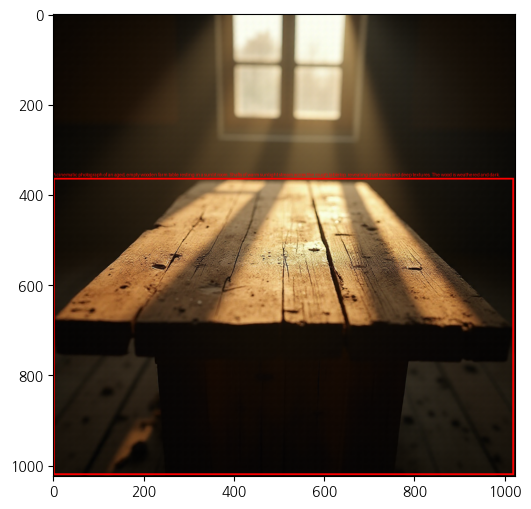

In [39]:
from helper_dev_utils import *

object_result = text_analyzer.detect_objects(background, background_scene)
logger.debug(background.info)

print_dic_tree(object_result)

logger.debug("=" * 60)
logger.debug("객체 탐지 결과 (Object Detection)")
logger.debug("=" * 60)
logger.debug(f"객체 이름 (Object): {object_result['object_name']}")
logger.debug(f"발견 여부 (Found): {object_result['found']}")

if object_result['found']:
    logger.debug(f"신뢰도 (Confidence): {object_result['confidence']:.2f}")
    logger.debug(f"바운딩 박스 (BBox): {object_result['bbox']}")
    logger.debug(f"  [xmin, ymin, xmax, ymax] = {object_result['bbox']}")
    
logger.debug(f"설명 (Description):")
logger.debug(f"  {object_result['description']}")
logger.debug("=" * 60)

background_with_box = image_normalized_bbox(background, object_result['bbox'], box_color="red", box_width=4, label=object_result['object_name'])
plt.figure(figsize=(6, 6))
plt.imshow(background_with_box)


2026-01-06 14:37:42 D [config:61] - [QwenVLAnalyzer] messages: [{'role': 'user', 'content': [{'type': 'image', 'image': '/tmp/qwen_detect_temp.png'}, {'type': 'text', 'text': 'Detect the \'the aged wooden table in the center. Provide the bounding box for the main tabletop surface where an object can be placed.\' in this image.\nIf found, return the bounding box in [xmin, ymin, xmax, ymax] format (0-1000).\n\nRespond in JSON format:\n{\n    "found": true/false,\n    "object_name": "the aged wooden table in the center. Provide the bounding box for the main tabletop surface where an object can be placed.",\n    "bbox": [xmin, ymin, xmax, ymax],\n    "confidence": 0.0-1.0,\n    "description": "Brief description of the object and its location"\n}'}]}]
2026-01-06 14:37:42 D [config:62] - [QwenVLAnalyzer] text: <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Detect the 'the aged wooden table in the center. Provide the bounding box for the main tabletop surface where an object can 

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2026-01-06 14:37:49 D [config:109] - [QwenVLAnalyzer] Raw output: ```json
{
    "found": true,
    "object_name": "the aged wooden table in the center. Provide the bounding box for the main tabletop surface where an object can be placed.",
    "bbox": [0, 356, 995, 753],
    "confidence": 0.98,
    "description": "The main tabletop surface of the aged wooden table, illuminated by sunlight streaming through a window, showing visible wood grain and texture."
}
```
2026-01-06 14:37:49 W [config:287] - [QwenVLAnalyzer] Failed to parse JSON, using default values
2026-01-06 14:37:49 D [config:5] - {}
2026-01-06 14:37:49 I [helper_utils_print:443] - ├─ found [bool]: False
2026-01-06 14:37:49 I [helper_utils_print:443] - ├─ object_name [str]: the aged wooden table in the center. Provide the bounding box for the main tabletop surface where an...
2026-01-06 14:37:49 I [helper_utils_print:389] - ├─ bbox [list]
2026-01-06 14:37:49 I [helper_utils_print:512] - │  ├─ [0] [int]: 0
2026-01-06 14:37:49

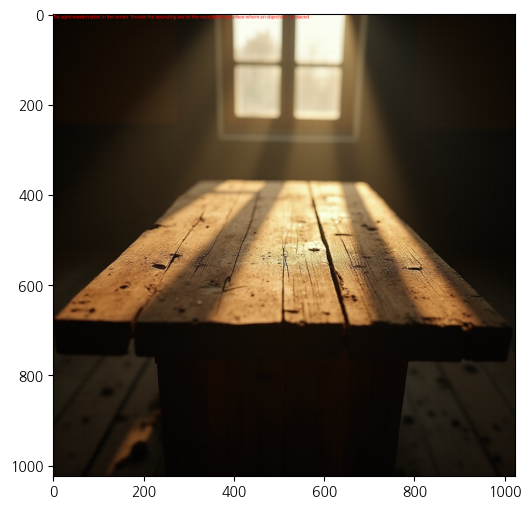

In [40]:
# 테스트 3: 객체 탐지 (detect_objects)
# background 이미지에서 "table" 객체를 탐지합니다.

object_result = text_analyzer.detect_objects(background, "the aged wooden table in the center. Provide the bounding box for the main tabletop surface where an object can be placed.")
logger.debug(background.info)

print_dic_tree(object_result)

logger.debug("=" * 60)
logger.debug("객체 탐지 결과 (Object Detection)")
logger.debug("=" * 60)
logger.debug(f"객체 이름 (Object): {object_result['object_name']}")
logger.debug(f"발견 여부 (Found): {object_result['found']}")

if object_result['found']:
    logger.debug(f"신뢰도 (Confidence): {object_result['confidence']:.2f}")
    logger.debug(f"바운딩 박스 (BBox): {object_result['bbox']}")
    logger.debug(f"  [xmin, ymin, xmax, ymax] = {object_result['bbox']}")
    
logger.debug(f"설명 (Description):")
logger.debug(f"  {object_result['description']}")
logger.debug("=" * 60)

background_with_box = image_normalized_bbox(background, object_result['bbox'], box_color="red", box_width=4, label=object_result['object_name'])
plt.figure(figsize=(6, 6))
plt.imshow(background_with_box)

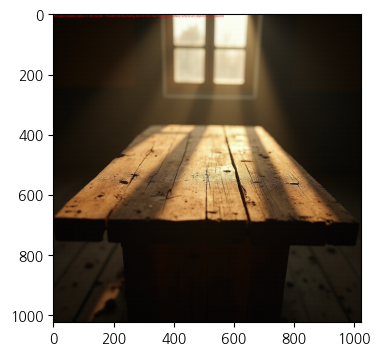

In [41]:
background_with_bbox = image_normalized_bbox(background, object_result['bbox'], box_color="red", box_width=5, label=object_result['object_name'])
plt.figure(figsize=(4, 4))
plt.imshow(background_with_bbox)
plt.show()


In [42]:
# 테스트 1: 텍스트 위치 분석 (analyze_text_position)
# background 이미지에서 텍스트 배치하기 좋은 위치를 추천받습니다.

position_result = text_analyzer.analyze_text_position(background)
flush_gpu()

logger.debug("=" * 60)
logger.debug("📍 텍스트 위치 분석 결과 (Text Position Analysis)")
logger.debug("=" * 60)
logger.debug(f"추천 위치 (Recommended): {position_result['recommended_position']}")
logger.debug(f"신뢰도 (Confidence): {position_result['confidence']:.2f}")
logger.debug(f"추천 이유 (Reasoning):")
logger.debug(f"  {position_result['reasoning']}")
logger.debug(f"대안 위치 (Alternatives): {', '.join(position_result['alternative_positions'])}")
logger.debug("=" * 60)

2026-01-06 14:37:53 D [config:61] - [QwenVLAnalyzer] messages: [{'role': 'user', 'content': [{'type': 'image', 'image': '/tmp/qwen_analyze_temp.png'}, {'type': 'text', 'text': 'Analyze this image and recommend the best position to place text overlay.\nConsider the following factors:\n1. Empty space availability\n2. Visual balance and composition\n3. Contrast for text readability\n4. Avoid covering important subjects\n\nRespond in JSON format:\n{\n    "recommended_position": "top|center|bottom|left|right",\n    "reasoning": "Explain why this position is best",\n    "confidence": 0.0-1.0,\n    "alternative_positions": ["position1", "position2"]\n}'}]}]
2026-01-06 14:37:53 D [config:62] - [QwenVLAnalyzer] text: <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Analyze this image and recommend the best position to place text overlay.
Consider the following factors:
1. Empty space availability
2. Visual balance and composition
3. Contrast for text readability
4. Avoid covering imp

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2026-01-06 14:38:00 D [config:109] - [QwenVLAnalyzer] Raw output: {
    "recommended_position": "bottom",
    "reasoning": "The bottom of the image offers a large area of relative darkness and shadow, which provides high contrast for text readability. It avoids covering the main subject (the wooden table) and the focal point (the sunlight on the table). The composition is balanced as the table occupies the center, and placing text at the bottom leaves the visual weight of the image intact. The dark floor area also minimizes distraction from the text.",
    "confidence": 0.95,
    "alternative_positions": ["top", "left"]
}
2026-01-06 14:38:03 D [config:7] - ============================================================
2026-01-06 14:38:03 D [config:8] - 📍 텍스트 위치 분석 결과 (Text Position Analysis)
2026-01-06 14:38:03 D [config:9] - ============================================================
2026-01-06 14:38:03 D [config:10] - 추천 위치 (Recommended): bottom
2026-01-06 14:38:03 D [config:11] - 신뢰도

In [43]:
# 테스트 2: 텍스트 탐지 (find_text_regions) - OCR
# background 이미지에서 텍스트를 탐지합니다.

text_detection_result = text_analyzer.find_text_regions(background)

logger.debug("=" * 60)
logger.debug("🔍 텍스트 탐지 결과 (Text Detection - OCR)")
logger.debug("=" * 60)
logger.debug(f"텍스트 존재 여부 (Has Text): {text_detection_result['has_text']}")
logger.debug(f"텍스트 내용 (Content): {text_detection_result['text_content']}")
logger.debug(f"텍스트 위치 (Locations): {len(text_detection_result['text_locations'])} regions found")

if text_detection_result['text_locations']:
    for i, loc in enumerate(text_detection_result['text_locations'], 1):
        logger.debug(f"  Region {i}:")
        logger.debug(f"    Text: {loc.get('text', 'N/A')}")
        logger.debug(f"    BBox: {loc.get('bbox', [0,0,0,0])}")

logger.debug(f"설명 (Description): {text_detection_result['description']}")
logger.debug("=" * 60)

2026-01-06 14:38:04 D [config:61] - [QwenVLAnalyzer] messages: [{'role': 'user', 'content': [{'type': 'image', 'image': '/tmp/qwen_ocr_temp.png'}, {'type': 'text', 'text': 'Detect all text in the image.\nReturn bounding boxes for each text region in [xmin, ymin, xmax, ymax] format (0-1000).\n\nRespond in JSON format:\n{\n    "has_text": true/false,\n    "text_content": "All detected text concatenated",\n    "text_locations": [\n        {"text": "word1", "bbox": [xmin, ymin, xmax, ymax]},\n        {"text": "word2", "bbox": [xmin, ymin, xmax, ymax]}\n    ],\n    "description": "Brief description of text locations"\n}'}]}]
2026-01-06 14:38:04 D [config:62] - [QwenVLAnalyzer] text: <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Detect all text in the image.
Return bounding boxes for each text region in [xmin, ymin, xmax, ymax] format (0-1000).

Respond in JSON format:
{
    "has_text": true/false,
    "text_content": "All detected text concatenated",
    "text_locations": [
  

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2026-01-06 14:38:06 D [config:109] - [QwenVLAnalyzer] Raw output: {
    "has_text": false,
    "text_content": "",
    "text_locations": [],
    "description": "No text detected in the image."
}
2026-01-06 14:38:06 D [config:6] - ============================================================
2026-01-06 14:38:06 D [config:7] - 🔍 텍스트 탐지 결과 (Text Detection - OCR)
2026-01-06 14:38:06 D [config:8] - ============================================================
2026-01-06 14:38:06 D [config:9] - 텍스트 존재 여부 (Has Text): False
2026-01-06 14:38:06 D [config:10] - 텍스트 내용 (Content): 
2026-01-06 14:38:06 D [config:11] - 텍스트 위치 (Locations): 0 regions found
2026-01-06 14:38:06 D [config:19] - 설명 (Description): No text detected in the image.
2026-01-06 14:38:06 D [config:20] - ============================================================


In [44]:
# 테스트 3: 객체 탐지 (detect_objects)
# background 이미지에서 "table" 객체를 탐지합니다.

object_result = text_analyzer.detect_objects(background, "table")

logger.debug("=" * 60)
logger.debug("객체 탐지 결과 (Object Detection)")
logger.debug("=" * 60)
logger.debug(f"객체 이름 (Object): {object_result['object_name']}")
logger.debug(f"발견 여부 (Found): {object_result['found']}")

if object_result['found']:
    logger.debug(f"신뢰도 (Confidence): {object_result['confidence']:.2f}")
    logger.debug(f"바운딩 박스 (BBox): {object_result['bbox']}")
    logger.debug(f"  [xmin, ymin, xmax, ymax] = {object_result['bbox']}")
    
logger.debug(f"설명 (Description):")
logger.debug(f"  {object_result['description']}")
logger.debug("=" * 60)

2026-01-06 14:38:06 D [config:61] - [QwenVLAnalyzer] messages: [{'role': 'user', 'content': [{'type': 'image', 'image': '/tmp/qwen_detect_temp.png'}, {'type': 'text', 'text': 'Detect the \'table\' in this image.\nIf found, return the bounding box in [xmin, ymin, xmax, ymax] format (0-1000).\n\nRespond in JSON format:\n{\n    "found": true/false,\n    "object_name": "table",\n    "bbox": [xmin, ymin, xmax, ymax],\n    "confidence": 0.0-1.0,\n    "description": "Brief description of the object and its location"\n}'}]}]
2026-01-06 14:38:06 D [config:62] - [QwenVLAnalyzer] text: <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Detect the 'table' in this image.
If found, return the bounding box in [xmin, ymin, xmax, ymax] format (0-1000).

Respond in JSON format:
{
    "found": true/false,
    "object_name": "table",
    "bbox": [xmin, ymin, xmax, ymax],
    "confidence": 0.0-1.0,
    "description": "Brief description of the object and its location"
}<|im_end|>
<|im_start|>assist

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2026-01-06 14:38:12 D [config:109] - [QwenVLAnalyzer] Raw output: ```json
{
    "found": true,
    "object_name": "table",
    "bbox": [0, 356, 995, 997],
    "confidence": 0.98,
    "description": "A rustic wooden table with visible grain and wear, illuminated by warm sunlight streaming through a window in the background."
}
```
2026-01-06 14:38:12 W [config:287] - [QwenVLAnalyzer] Failed to parse JSON, using default values
2026-01-06 14:38:12 D [config:6] - ============================================================
2026-01-06 14:38:12 D [config:7] - 객체 탐지 결과 (Object Detection)
2026-01-06 14:38:12 D [config:8] - ============================================================
2026-01-06 14:38:12 D [config:9] - 객체 이름 (Object): table
2026-01-06 14:38:12 D [config:10] - 발견 여부 (Found): False
2026-01-06 14:38:12 D [config:17] - 설명 (Description):
2026-01-06 14:38:12 D [config:18] -   Failed to parse model output
2026-01-06 14:38:12 D [config:19] - =============================================

In [45]:
# 테스트 4: 프롬프트 기반 좌표 출력 (Custom Prompt)
# 사용자가 원하는 프롬프트로 좌표를 출력합니다.

custom_prompt = """Find the brightest area in this image where we can place advertisement text.
Return the position in JSON format:
{
    "position_name": "descriptive name",
    "bbox": [xmin, ymin, xmax, ymax],
    "reason": "why this area is suitable"
}"""

# 이미지를 임시 파일로 저장
temp_path = "/tmp/qwen_custom_temp.png"
background.save(temp_path)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": temp_path},
            {"type": "text", "text": custom_prompt}
        ]
    }
]

custom_result = text_analyzer._run_inference(messages, max_tokens=512, temperature=0)

logger.debug("=" * 60)
logger.debug("💡 커스텀 프롬프트 결과 (Custom Prompt Result)")
logger.debug("=" * 60)
logger.debug("프롬프트 (Prompt):")
logger.debug(custom_prompt)
logger.debug("\n결과 (Result):")
logger.debug(custom_result)
logger.debug("=" * 60)

# JSON 파싱 시도
try:
    custom_dict = json.loads(custom_result)
    logger.debug("\n파싱된 결과 (Parsed JSON):")
    for key, value in custom_dict.items():
        logger.debug(f"  {key}: {value}")
except:
    logger.debug("\n(JSON 파싱 실패 - 원문 출력)")
    
logger.debug("=" * 60)

2026-01-06 14:38:12 D [config:61] - [QwenVLAnalyzer] messages: [{'role': 'user', 'content': [{'type': 'image', 'image': '/tmp/qwen_custom_temp.png'}, {'type': 'text', 'text': 'Find the brightest area in this image where we can place advertisement text.\nReturn the position in JSON format:\n{\n    "position_name": "descriptive name",\n    "bbox": [xmin, ymin, xmax, ymax],\n    "reason": "why this area is suitable"\n}'}]}]
2026-01-06 14:38:12 D [config:62] - [QwenVLAnalyzer] text: <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Find the brightest area in this image where we can place advertisement text.
Return the position in JSON format:
{
    "position_name": "descriptive name",
    "bbox": [xmin, ymin, xmax, ymax],
    "reason": "why this area is suitable"
}<|im_end|>
<|im_start|>assistant

2026-01-06 14:38:12 D [config:105] - [QwenVLAnalyzer] Running inference...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2026-01-06 14:38:18 D [config:109] - [QwenVLAnalyzer] Raw output: {
    "position_name": "Center of the illuminated tabletop",
    "bbox": [200, 355, 780, 675],
    "reason": "This area is the brightest part of the image, directly under the window's light beam. The high contrast between the illuminated wood and the surrounding shadows ensures that any text placed here will be highly visible and stand out, maximizing readability and impact."
}
2026-01-06 14:38:18 D [config:28] - ============================================================
2026-01-06 14:38:18 D [config:29] - 💡 커스텀 프롬프트 결과 (Custom Prompt Result)
2026-01-06 14:38:18 D [config:30] - ============================================================
2026-01-06 14:38:18 D [config:31] - 프롬프트 (Prompt):
2026-01-06 14:38:18 D [config:32] - Find the brightest area in this image where we can place advertisement text.
Return the position in JSON format:
{
    "position_name": "descriptive name",
    "bbox": [xmin, ymin, xmax, ymax],
    "

In [46]:
# 리소스 정리 (Cleanup)
text_analyzer.cleanup()
flush_gpu()

if "text_analyzer" in globals():
    del text_analyzer
    text_analyzer = None

logger.info("QwenVLAnalyzer cleaned up and removed from memory")

2026-01-06 14:38:18 I [config:323] - [QwenVLAnalyzer] Cleaning up resources...


[rank0]:[W106 05:38:21.154186479 ProcessGroupNCCL.cpp:1524] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


2026-01-06 14:38:25 I [config:329] - [QwenVLAnalyzer] Cleanup completed
2026-01-06 14:38:25 I [config:9] - QwenVLAnalyzer cleaned up and removed from memory


In [47]:
# QwenVLAnalyzer 테스트
# # 분석기 초기화 (Qwen3-VL-8B-Instruct-FP8 사용)
text_analyzer = QwenVLAnalyzer(model_id="Qwen/Qwen3-VL-8B-Instruct-FP8", device="cuda")
# background 이미지에서 텍스트 위치 분석
flush_gpu()
position_result = text_analyzer.analyze_text_position(background)
text_analyzer.cleanup()
flush_gpu()

logger.debug("=" * 50)
logger.debug("텍스트 위치 분석 결과:")
logger.debug("=" * 50)
logger.debug(f"추천 위치: {position_result['recommended_position']}")
logger.debug(f"신뢰도: {position_result['confidence']}")
logger.debug(f"추천 이유: {position_result['reasoning']}")
logger.debug(f"대안 위치: {position_result['alternative_positions']}")
logger.debug("=" * 50)

2026-01-06 14:38:25 I [config:31] - [QwenVLAnalyzer] Loading model: Qwen/Qwen3-VL-8B-Instruct-FP8
INFO 01-06 05:38:29 [utils.py:253] non-default args: {'trust_remote_code': True, 'max_model_len': 8192, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True, 'enforce_eager': True, 'model': 'Qwen/Qwen3-VL-8B-Instruct-FP8'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 01-06 05:38:30 [model.py:514] Resolved architecture: Qwen3VLForConditionalGeneration
INFO 01-06 05:38:30 [model.py:1661] Using max model len 8192
INFO 01-06 05:38:30 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-06 05:38:30 [vllm.py:622] Enforce eager set, overriding optimization level to -O0
INFO 01-06 05:38:30 [vllm.py:722] Cudagraph is disabled under eager mode
(EngineCore_DP0 pid=246799) INFO 01-06 05:38:48 [core.py:93] Initializing a V1 LLM engine (v0.13.0) with config: model='Qwen/Qwen3-VL-8B-Instruct-FP8', speculative_config=None, tokenizer='Qwen/Qwen3-VL-8B-Instruct-FP8', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=fp8, enforce_eager=True, kv_cache_dtype=auto, device_con

(EngineCore_DP0 pid=246799) /home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:174: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=246799) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=246799)   warnings.warn(


(EngineCore_DP0 pid=246799) INFO 01-06 05:39:07 [cuda.py:351] Using FLASH_ATTN attention backend out of potential backends: ('FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION')


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:23<00:23, 23.02s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:39<00:00, 19.18s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:39<00:00, 19.76s/it]
(EngineCore_DP0 pid=246799) 


(EngineCore_DP0 pid=246799) INFO 01-06 05:39:47 [default_loader.py:308] Loading weights took 39.66 seconds
(EngineCore_DP0 pid=246799) INFO 01-06 05:39:48 [gpu_model_runner.py:3659] Model loading took 10.3137 GiB memory and 49.095342 seconds
(EngineCore_DP0 pid=246799) INFO 01-06 05:39:48 [gpu_model_runner.py:4446] Encoder cache will be initialized with a budget of 16384 tokens, and profiled with 1 image items of the maximum feature size.
(EngineCore_DP0 pid=246799) WARNING 01-06 05:40:09 [fp8_utils.py:1027] Using default W8A8 Block FP8 kernel config. Performance might be sub-optimal! Config file not found at /home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/vllm/model_executor/layers/quantization/utils/configs/N=6144,K=4096,device_name=NVIDIA_L4,dtype=fp8_w8a8,block_shape=[128,128].json
(EngineCore_DP0 pid=246799) WARNING 01-06 05:40:09 [fp8_utils.py:1027] Using default W8A8 Block FP8 kernel config. Performance might be sub-optimal! Config file not found at /home/sp

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2026-01-06 14:40:32 D [config:109] - [QwenVLAnalyzer] Raw output: {
    "recommended_position": "bottom",
    "reasoning": "The bottom of the image offers a large area of relative darkness and empty space, which provides a strong contrast for text readability without obscuring the main subject (the wooden table). Placing text here maintains visual balance, as the table and window are the central focus, and the bottom area doesn't interfere with the dramatic lighting and composition. The dark floor area also helps the text stand out without competing with the illuminated table surface.",
    "confidence": 0.95,
    "alternative_positions": ["top", "left"]
}
2026-01-06 14:40:32 I [config:323] - [QwenVLAnalyzer] Cleaning up resources...


[rank0]:[W106 05:40:34.208171497 ProcessGroupNCCL.cpp:1524] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


2026-01-06 14:40:39 I [config:329] - [QwenVLAnalyzer] Cleanup completed
2026-01-06 14:40:40 D [config:10] - ==================================================
2026-01-06 14:40:40 D [config:11] - 텍스트 위치 분석 결과:
2026-01-06 14:40:40 D [config:12] - ==================================================
2026-01-06 14:40:40 D [config:13] - 추천 위치: bottom
2026-01-06 14:40:40 D [config:14] - 신뢰도: 0.95
2026-01-06 14:40:40 D [config:15] - 추천 이유: The bottom of the image offers a large area of relative darkness and empty space, which provides a strong contrast for text readability without obscuring the main subject (the wooden table). Placing text here maintains visual balance, as the table and window are the central focus, and the bottom area doesn't interfere with the dramatic lighting and composition. The dark floor area also helps the text stand out without competing with the illuminated table surface.
2026-01-06 14:40:40 D [config:16] - 대안 위치: ['top', 'left']
2026-01-06 14:40:40 D [config:17] - ==

In [49]:
# 기존 텍스트 탐지 테스트
text_analyzer = QwenVLAnalyzer(model_id="Qwen/Qwen3-VL-8B-Instruct-FP8", device="cuda")
text_detection_result = text_analyzer.find_text_regions(background)

logger.debug("=" * 50)
logger.debug("텍스트 탐지 결과:")
logger.debug("=" * 50)
logger.debug(f"텍스트 존재 여부: {text_detection_result['has_text']}")
logger.debug(f"텍스트 내용: {text_detection_result['text_content']}")
logger.debug(f"텍스트 위치: {text_detection_result['text_locations']}")
logger.debug(f"설명: {text_detection_result['description']}")
logger.debug("=" * 50)

2026-01-06 14:46:37 I [config:31] - [QwenVLAnalyzer] Loading model: Qwen/Qwen3-VL-8B-Instruct-FP8
INFO 01-06 05:46:41 [utils.py:253] non-default args: {'trust_remote_code': True, 'max_model_len': 8192, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True, 'enforce_eager': True, 'model': 'Qwen/Qwen3-VL-8B-Instruct-FP8'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 01-06 05:46:42 [model.py:514] Resolved architecture: Qwen3VLForConditionalGeneration
INFO 01-06 05:46:42 [model.py:1661] Using max model len 8192
INFO 01-06 05:46:42 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-06 05:46:42 [vllm.py:622] Enforce eager set, overriding optimization level to -O0
INFO 01-06 05:46:42 [vllm.py:722] Cudagraph is disabled under eager mode
(EngineCore_DP0 pid=247509) INFO 01-06 05:46:57 [core.py:93] Initializing a V1 LLM engine (v0.13.0) with config: model='Qwen/Qwen3-VL-8B-Instruct-FP8', speculative_config=None, tokenizer='Qwen/Qwen3-VL-8B-Instruct-FP8', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=fp8, enforce_eager=True, kv_cache_dtype=auto, device_con

(EngineCore_DP0 pid=247509) /home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:174: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=247509) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=247509)   warnings.warn(


(EngineCore_DP0 pid=247509) INFO 01-06 05:47:13 [cuda.py:351] Using FLASH_ATTN attention backend out of potential backends: ('FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION')


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:01<00:01,  1.71s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:07<00:00,  3.85s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:07<00:00,  3.53s/it]
(EngineCore_DP0 pid=247509) 


(EngineCore_DP0 pid=247509) INFO 01-06 05:47:21 [default_loader.py:308] Loading weights took 7.21 seconds
(EngineCore_DP0 pid=247509) INFO 01-06 05:47:21 [gpu_model_runner.py:3659] Model loading took 10.3137 GiB memory and 14.544397 seconds
(EngineCore_DP0 pid=247509) INFO 01-06 05:47:22 [gpu_model_runner.py:4446] Encoder cache will be initialized with a budget of 16384 tokens, and profiled with 1 image items of the maximum feature size.
(EngineCore_DP0 pid=247509) WARNING 01-06 05:47:37 [fp8_utils.py:1027] Using default W8A8 Block FP8 kernel config. Performance might be sub-optimal! Config file not found at /home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/vllm/model_executor/layers/quantization/utils/configs/N=6144,K=4096,device_name=NVIDIA_L4,dtype=fp8_w8a8,block_shape=[128,128].json
(EngineCore_DP0 pid=247509) WARNING 01-06 05:47:37 [fp8_utils.py:1027] Using default W8A8 Block FP8 kernel config. Performance might be sub-optimal! Config file not found at /home/spa

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2026-01-06 14:47:44 D [config:109] - [QwenVLAnalyzer] Raw output: {
    "has_text": false,
    "text_content": "",
    "text_locations": [],
    "description": "No text detected in the image."
}
2026-01-06 14:47:44 D [config:5] - ==================================================
2026-01-06 14:47:44 D [config:6] - 텍스트 탐지 결과:
2026-01-06 14:47:44 D [config:7] - ==================================================
2026-01-06 14:47:44 D [config:8] - 텍스트 존재 여부: False
2026-01-06 14:47:44 D [config:9] - 텍스트 내용: 
2026-01-06 14:47:44 D [config:10] - 텍스트 위치: []
2026-01-06 14:47:44 D [config:11] - 설명: No text detected in the image.
2026-01-06 14:47:44 D [config:12] - ==================================================


In [50]:
# text_analyzer 재생성 (cleanup 후 다시 사용하려면 필수)
if "text_analyzer" not in globals() or text_analyzer is None:
    logger.info("Recreating QwenVLAnalyzer instance...")
    text_analyzer = QwenVLAnalyzer(model_id="Qwen/Qwen3-VL-8B-Instruct-FP8", device="cuda")
    logger.info("QwenVLAnalyzer instance recreated successfully")

In [51]:
# 모델 메모리 정리
text_analyzer.cleanup()
logger.debug("QwenVLAnalyzer cleaned up")

2026-01-06 14:47:45 I [config:323] - [QwenVLAnalyzer] Cleaning up resources...


[rank0]:[W106 05:47:45.622408040 ProcessGroupNCCL.cpp:1524] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


2026-01-06 14:47:46 I [config:329] - [QwenVLAnalyzer] Cleanup completed
2026-01-06 14:47:46 D [config:3] - QwenVLAnalyzer cleaned up


In [52]:
if "text_analyzer" in globals():
    del text_analyzer
    text_analyzer = None

2026-01-06 14:55:00 D [config:21] - Best position: bottom scores {'top': 101626, 'center': 63141, 'bottom': 239694}


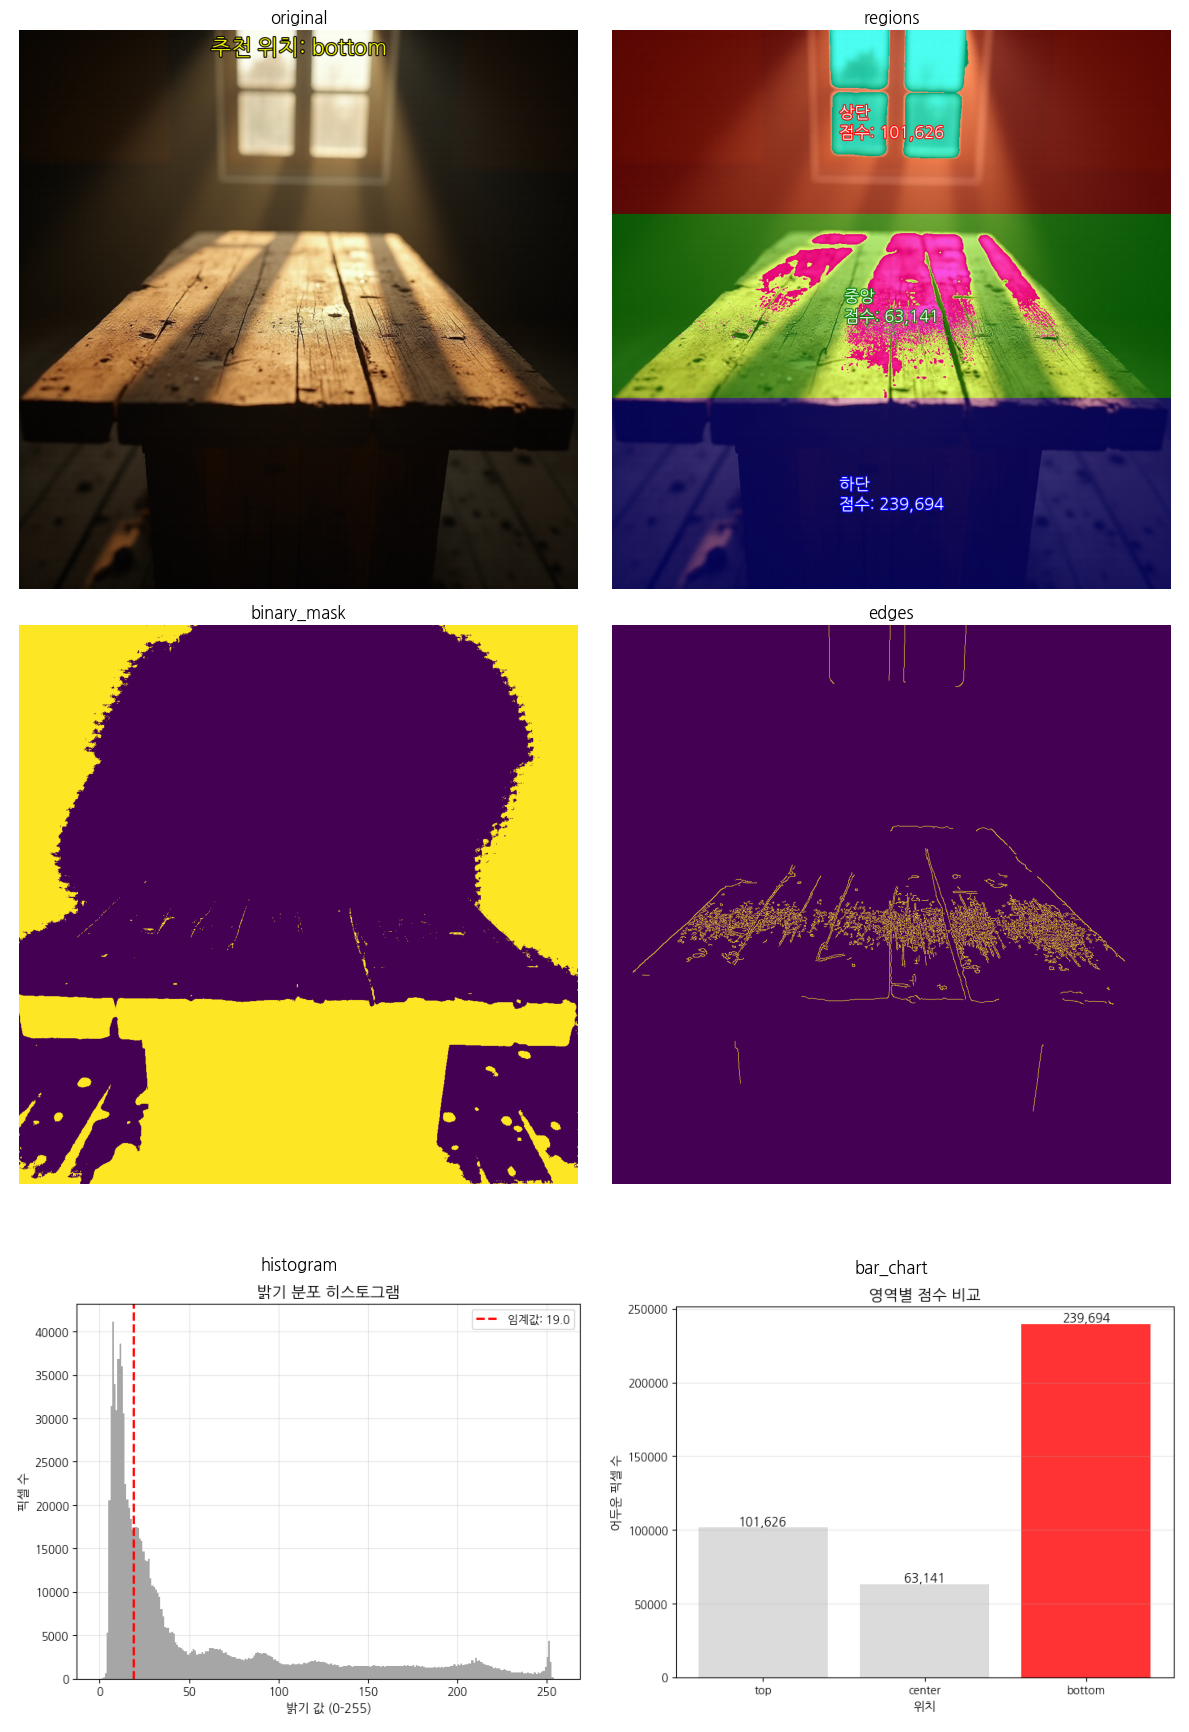

In [54]:
import math
flux_gen = FluxGenerator()

best_position, scores, images = flux_gen.position_analysis(background=background)
n = len(images)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*6))
for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        if idx < n:
            key = list(images.keys())[idx]
            axes[i, j].imshow(images[key])
            axes[i, j].set_title(key)
            axes[i, j].axis("off")
        else:
            axes[i, j].axis("off")
plt.tight_layout()

logger.debug(f"Best position: {best_position} scores {scores}")
plt.show()


In [55]:
# Step 3: 자동 위치 결정 + 특성 주입
from utils.MaskGenerator import MaskGenerator

# 상품을 배경 크기에 맞게 배치할 좌표 계산
product_width = int(background.width * 0.4)
product_height = int(sm_result.height * (product_width / sm_result.width))
product_resized = sm_result.resize((product_width, product_height), Image.LANCZOS)
mask_resized = sm_mask.resize((product_width, product_height), Image.LANCZOS)

# 2. 배경 크기 마스크 생성
full_mask = Image.new("L", background.size, 0)

# best_position에 따라 x, y 좌표 자동 계산
if best_position == "top":
    x = (background.width - product_width) // 2
    y = 100
elif best_position == "center":
    x = (background.width - product_width) // 2
    y = (background.height - product_height) // 2
else:  # "bottom"
    x = (background.width - product_width) // 2
    y = background.height - product_height - 100

full_mask.paste(mask_resized, (x, y))
logger.debug(f"Position: {best_position}, (x={x}, y={y})")


2026-01-06 14:57:30 D [config:25] - Position: bottom, (x=307, y=515)


In [56]:

# 실행
result = flux_gen.inject_features_via_inpaint(
    background=background,
    product_foreground=product_resized,
    product_mask=full_mask,
    position=(x, y),
    prompt="A ripe yellow banana with natural contact shadow on the table",
    negative_prompt=None,
    strength=0.5,
    guidance_scale=3.5,
    seed=42,
    mask_dilation=30,
    progress_callback=progress_callback
)


2026-01-06 14:57:30 I [config:368] - [FluxGenerator] Loading FLUX Inpainting for feature injection...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-06 14:59:39 I [config:393] - [FluxGenerator] Dilating mask by 30 pixels for natural shadows...
2026-01-06 14:59:40 I [config:414] - [FluxGenerator] prompt='A ripe yellow banana with natural contact shadow on the table'
2026-01-06 14:59:40 I [config:415] - [FluxGenerator] negative_prompt=''
2026-01-06 14:59:40 I [config:416] - [FluxGenerator] strength='0.5', guidance_scale=3.5, steps=28


  0%|          | 0/14 [00:00<?, ?it/s]

/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


2026-01-06 15:00:44 D [config:4] - [Test Progress] flux_feature_injection: 1/28
2026-01-06 15:00:47 D [config:4] - [Test Progress] flux_feature_injection: 2/28
2026-01-06 15:00:50 D [config:4] - [Test Progress] flux_feature_injection: 3/28
2026-01-06 15:00:52 D [config:4] - [Test Progress] flux_feature_injection: 4/28
2026-01-06 15:00:55 D [config:4] - [Test Progress] flux_feature_injection: 5/28
2026-01-06 15:00:57 D [config:4] - [Test Progress] flux_feature_injection: 6/28
2026-01-06 15:01:00 D [config:4] - [Test Progress] flux_feature_injection: 7/28
2026-01-06 15:01:02 D [config:4] - [Test Progress] flux_feature_injection: 8/28
2026-01-06 15:01:05 D [config:4] - [Test Progress] flux_feature_injection: 9/28
2026-01-06 15:01:07 D [config:4] - [Test Progress] flux_feature_injection: 10/28
2026-01-06 15:01:10 D [config:4] - [Test Progress] flux_feature_injection: 11/28
2026-01-06 15:01:12 D [config:4] - [Test Progress] flux_feature_injection: 12/28
2026-01-06 15:01:15 D [config:4] - [T

The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-06 15:01:21 I [config:431] - [FluxGenerator] Feature injection completed


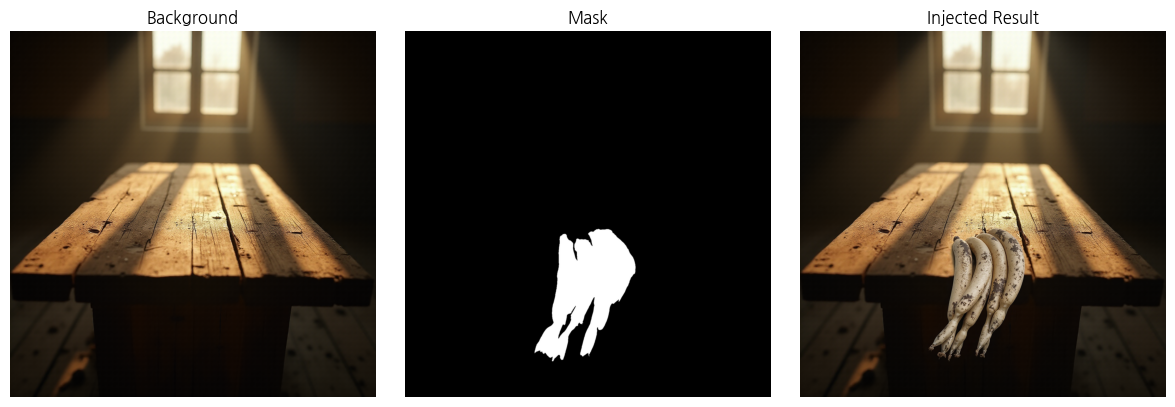

In [57]:

# 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(background)
plt.title("Background")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(full_mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title("Injected Result")
plt.axis("off")
plt.tight_layout()
plt.show()
